In [1]:
import numpy as np

def transform_img2pc(img):
    img_array = np.asarray(img)
    indices = np.argwhere(img_array > 30)
    return indices.astype(np.float32)

In [2]:
!mkdir figures
!mkdir checkpoints

A subdirectory or file figures already exists.
A subdirectory or file checkpoints already exists.


Files already downloaded and verified


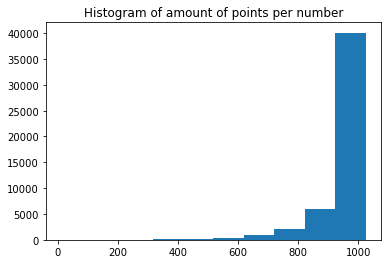

In [3]:
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import torchvision

transforms = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1)])
                                   

dataset = CIFAR10(root='.././data', train=True, download=True, transform=transforms)
len_points = []
# loop over samples
for idx in range(len(dataset)):
    img,label = dataset[idx]
    pc = transform_img2pc(img)
    len_points.append(len(pc))
#print(min(len_points), max(len_points))    
    
h = plt.hist(len_points)
plt.title('Histogram of amount of points per number')
plt.savefig('figures/histogram_points_cifar.png',dpi=100)

In [4]:
max(len_points)

1024

In [5]:
from torch.utils.data import Dataset
import torch

class CIFAR3D(Dataset):
    """3D MNIST dataset."""
    
    NUM_CLASSIFICATION_CLASSES = 10
    POINT_DIMENSION = 3

    def __init__(self, dataset, num_points):
        self.dataset = dataset
        self.number_of_points = num_points

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        img,label = dataset[idx]
        pc = transform_img2pc(img)
        
        if self.number_of_points-pc.shape[0]>0:
            # Duplicate points
            sampling_indices = np.random.choice(pc.shape[0], self.number_of_points-pc.shape[0])
            new_points = pc[sampling_indices, :]
            pc = np.concatenate((pc, new_points),axis=0)
        else:
            # sample points
            sampling_indices = np.random.choice(pc.shape[0], self.number_of_points)
            pc = pc[sampling_indices, :]
            
        pc = pc.astype(np.float32)
        # add z
        noise = np.random.normal(0,0.05,len(pc))
        noise = np.expand_dims(noise, 1)
        pc = np.hstack([pc, noise]).astype(np.float32)
        pc = torch.tensor(pc)
        
        return pc, label

In [6]:
dataset='MNIST3D'
number_of_points=400
batch_size=128
learning_rate=0.1
number_of_workers=0

In [7]:
import torch
from torch.utils.data import DataLoader,random_split

transforms = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1)])

train_dataset = CIFAR10(root='.././data', download=True, train=True, transform = transforms)
test_dataset = CIFAR10(root='.././data', download=True, train=False, transform = transforms)
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

dataset_3d = CIFAR3D(dataset, number_of_points)
l_data = len(dataset_3d)
train_dataset, val_dataset, test_dataset = random_split(dataset_3d,
                                          [round(0.8*l_data), round(0.1*l_data), round(0.1*l_data)],
                                          generator=torch.Generator().manual_seed(1))

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


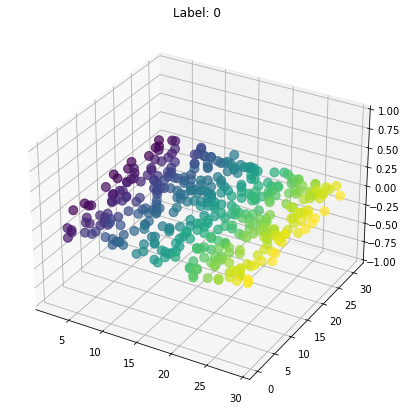

In [8]:
pc = train_dataset[1][0].numpy()
label = train_dataset[1][1]
fig = plt.figure(figsize=[7,7])
ax = plt.axes(projection='3d')
sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=80, marker='o', cmap="viridis", alpha=0.7)
ax.set_zlim3d(-1, 1)
plt.title(f'Label: {label}')
plt.savefig(f'figures/sample3d',dpi=100)


In [9]:
import plotly.graph_objects as go

def rotate_z(x, y, z, theta):
    w = x+1j*y
    return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

def plot_animated_3d(pc, xaxis_range=[-0.6,0.6], point_size=5):

    # Helix equation
    t = np.linspace(0, 10, 50)
    x, y, z = pc[:,2], pc[:,1], -pc[:,0]

    fig= go.Figure(go.Scatter3d(x=x, y=y, z=z, mode='markers', 
                                marker=dict(
                                            size=point_size,
                                            color=z,                # set color to an array of desired values
                                            colorscale='Viridis',   # choose a colorscale
                                            opacity=0.8
                                        )))
    x_eye = -1.25
    y_eye = 2
    z_eye = 0.5

    fig.update_layout(
             title='Animation Test',
             width=500,
             height=500,
             scene = dict(xaxis = dict(nticks=4, range=xaxis_range),),
             scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
             updatemenus=[dict(type='buttons', 
                      showactive=False,
                      y=1,
                      x=0.8,
                      xanchor='left',
                      yanchor='bottom',
                      pad=dict(t=45, r=10),
                      buttons=[dict(label='Play',
                                     method='animate',
                                     args=[None, dict(frame=dict(duration=10, redraw=True), 
                                                                 transition=dict(duration=00),
                                                                 fromcurrent=True,
                                                                 mode='immediate')])
                               ])]
                      )
    frames=[]
    for t in np.arange(0, 6.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(go.Frame(layout=dict(scene_camera_eye=dict(x=xe, y=ye, z=ze))))
    fig.frames=frames
    fig.show()

plot_animated_3d(pc)

In [10]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
  
class TransformationNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(TransformationNet, self).__init__()
        self.output_dim = output_dim

        self.conv_1 = nn.Conv1d(input_dim, 64, 1)
        self.conv_2 = nn.Conv1d(64, 128, 1)
        self.conv_3 = nn.Conv1d(128, 256, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(128)
        self.bn_3 = nn.BatchNorm1d(256)
        self.bn_4 = nn.BatchNorm1d(256)
        self.bn_5 = nn.BatchNorm1d(128)

        self.fc_1 = nn.Linear(256, 256)
        self.fc_2 = nn.Linear(256, 128)
        self.fc_3 = nn.Linear(128, self.output_dim*self.output_dim)

    def forward(self, x):
        num_points = x.shape[1]
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))

        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 256)

        x = F.relu(self.bn_4(self.fc_1(x)))
        x = F.relu(self.bn_5(self.fc_2(x)))
        x = self.fc_3(x)

        identity_matrix = torch.eye(self.output_dim)
        if torch.cuda.is_available():
            identity_matrix = identity_matrix.cuda()
        x = x.view(-1, self.output_dim, self.output_dim) + identity_matrix
        return x


class BasePointNet(nn.Module):

    def __init__(self, point_dimension):
        super(BasePointNet, self).__init__()
        self.input_transform = TransformationNet(input_dim=point_dimension, output_dim=point_dimension)
        self.feature_transform = TransformationNet(input_dim=64, output_dim=64)
        
        self.conv_1 = nn.Conv1d(point_dimension, 64, 1)
        self.conv_2 = nn.Conv1d(64, 64, 1)
        self.conv_3 = nn.Conv1d(64, 64, 1)
        self.conv_4 = nn.Conv1d(64, 128, 1)
        self.conv_5 = nn.Conv1d(128, 256, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(64)
        self.bn_3 = nn.BatchNorm1d(64)
        self.bn_4 = nn.BatchNorm1d(128)
        self.bn_5 = nn.BatchNorm1d(256)
        

    def forward(self, x, plot=False):
        num_points = x.shape[1]
        
        input_transform = self.input_transform(x) # T-Net tensor [batch, 3, 3]
        x = torch.bmm(x, input_transform) # Batch matrix-matrix product 
        x = x.transpose(2, 1) 
        tnet_out=x.cpu().detach().numpy()
        
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = x.transpose(2, 1)

        feature_transform = self.feature_transform(x) # T-Net tensor [batch, 64, 64]
        x = torch.bmm(x, feature_transform)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_3(self.conv_3(x)))
        x = F.relu(self.bn_4(self.conv_4(x)))
        x = F.relu(self.bn_5(self.conv_5(x)))
        x, ix = nn.MaxPool1d(num_points, return_indices=True)(x)  # max-pooling
        x = x.view(-1, 256)  # global feature vector 

        return x, feature_transform, tnet_out, ix


class ClassificationPointNet(nn.Module):

    def __init__(self, num_classes, dropout=0.3, point_dimension=3):
        super(ClassificationPointNet, self).__init__()
        self.base_pointnet = BasePointNet(point_dimension=point_dimension)

        self.fc_1 = nn.Linear(256, 128)
        self.fc_2 = nn.Linear(128, 64)
        self.fc_3 = nn.Linear(64, num_classes)

        self.bn_1 = nn.BatchNorm1d(128)
        self.bn_2 = nn.BatchNorm1d(64)

        self.dropout_1 = nn.Dropout(dropout)

    def forward(self, x):
        x, feature_transform, tnet_out, ix_maxpool = self.base_pointnet(x)

        x = F.relu(self.bn_1(self.fc_1(x)))
        x = F.relu(self.bn_2(self.fc_2(x)))
        x = self.dropout_1(x)

        return F.log_softmax(self.fc_3(x), dim=1), feature_transform, tnet_out, ix_maxpool


In [11]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os

model = ClassificationPointNet(num_classes=dataset_3d.NUM_CLASSIFICATION_CLASSES,
                                   point_dimension=dataset_3d.POINT_DIMENSION)
if torch.cuda.is_available():
    model.cuda()
    device = 'cuda'
else:
    device = 'cpu'

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [12]:
!pip install prettytable
from prettytable import PrettyTable

table = PrettyTable(["Modules", "Parameters"])
total_params = 0
for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    params = parameter.numel()
    table.add_row([name, params])
    total_params+=params
print(table)
print(f"Total Trainable Params: {total_params}")


+-----------------------------------------------+------------+
|                    Modules                    | Parameters |
+-----------------------------------------------+------------+
|  base_pointnet.input_transform.conv_1.weight  |    192     |
|   base_pointnet.input_transform.conv_1.bias   |     64     |
|  base_pointnet.input_transform.conv_2.weight  |    8192    |
|   base_pointnet.input_transform.conv_2.bias   |    128     |
|  base_pointnet.input_transform.conv_3.weight  |   32768    |
|   base_pointnet.input_transform.conv_3.bias   |    256     |
|   base_pointnet.input_transform.bn_1.weight   |     64     |
|    base_pointnet.input_transform.bn_1.bias    |     64     |
|   base_pointnet.input_transform.bn_2.weight   |    128     |
|    base_pointnet.input_transform.bn_2.bias    |    128     |
|   base_pointnet.input_transform.bn_3.weight   |    256     |
|    base_pointnet.input_transform.bn_3.bias    |    256     |
|   base_pointnet.input_transform.bn_4.weight   |    25

In [13]:
# training model
epochs=15
train_loss = []
test_loss = []
train_acc = []
test_acc = []
best_loss= np.inf

for epoch in tqdm(range(epochs)):
    epoch_train_loss = []
    epoch_train_acc = []

    # training loop
    for data in train_dataloader:
        points, targets = data  # [batch, num_points, 3] [batch]

        if torch.cuda.is_available():
            points, targets = points.cuda(), targets.cuda()
        if points.shape[0] <= 1:
            continue
        optimizer.zero_grad()
        model = model.train()
        preds, feature_transform, tnet_out, ix_maxpool = model(points)

        identity = torch.eye(feature_transform.shape[-1])
        if torch.cuda.is_available():
            identity = identity.cuda()
        regularization_loss = torch.norm(
            identity - torch.bmm(feature_transform, feature_transform.transpose(2, 1)))
        # Loss
        loss = F.nll_loss(preds, targets) + 0.001 * regularization_loss
        epoch_train_loss.append(loss.cpu().item())
        loss.backward()
        optimizer.step()
        preds = preds.data.max(1)[1]
        corrects = preds.eq(targets.data).cpu().sum()

        accuracy = corrects.item() / float(batch_size)
        epoch_train_acc.append(accuracy)

    epoch_test_loss = []
    epoch_test_acc = []

    # validation loop
    for batch_number, data in enumerate(test_dataloader):
        points, targets = data
        if torch.cuda.is_available():
            points, targets = points.cuda(), targets.cuda()
        model = model.eval()
        preds, feature_transform, tnet_out, ix = model(points)
        loss = F.nll_loss(preds, targets)
        epoch_test_loss.append(loss.cpu().item())
        preds = preds.data.max(1)[1]
        corrects = preds.eq(targets.data).cpu().sum()
        accuracy = corrects.item() / float(batch_size)
        epoch_test_acc.append(accuracy)

    print('Epoch %s: train loss: %s, val loss: %f, train accuracy: %s,  val accuracy: %f'
              % (epoch,
                round(np.mean(epoch_train_loss), 4),
                round(np.mean(epoch_test_loss), 4),
                round(np.mean(epoch_train_acc), 4),
                round(np.mean(epoch_test_acc), 4)))

    if np.mean(test_loss) < best_loss:
        state = {
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict()
        }
        torch.save(state, os.path.join('checkpoints', '3Dmnist_checkpoint_%s.pth' % (number_of_points)))
        best_loss=np.mean(test_loss)

    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))
    train_acc.append(np.mean(epoch_train_acc))
    test_acc.append(np.mean(epoch_test_acc))


  0%|          | 0/15 [00:00<?, ?it/s]

c:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\torch\nn\functional.py:651: UserWarning:

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.



Epoch 0: train loss: 2.8481, val loss: 2.312200, train accuracy: 0.0991,  val accuracy: 0.097700


c:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

c:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars



Epoch 1: train loss: 2.3127, val loss: 2.305000, train accuracy: 0.0979,  val accuracy: 0.101900
Epoch 2: train loss: 2.3128, val loss: 2.306100, train accuracy: 0.0994,  val accuracy: 0.097400
Epoch 3: train loss: 2.3132, val loss: 2.305600, train accuracy: 0.0984,  val accuracy: 0.099400
Epoch 4: train loss: 2.3127, val loss: 2.305700, train accuracy: 0.0985,  val accuracy: 0.097700
Epoch 5: train loss: 2.3131, val loss: 2.308000, train accuracy: 0.1004,  val accuracy: 0.101900
Epoch 6: train loss: 2.3143, val loss: 2.306300, train accuracy: 0.0988,  val accuracy: 0.105900
Epoch 7: train loss: 2.3134, val loss: 2.305200, train accuracy: 0.1005,  val accuracy: 0.105900
Epoch 8: train loss: 2.3144, val loss: 2.309200, train accuracy: 0.1016,  val accuracy: 0.101900
Epoch 9: train loss: 2.3151, val loss: 2.307000, train accuracy: 0.0975,  val accuracy: 0.105900
Epoch 10: train loss: 2.3137, val loss: 2.310000, train accuracy: 0.0978,  val accuracy: 0.105200
Epoch 11: train loss: 2.315, 

In [14]:
# plot loss and accuracy

def plot_losses(train_loss, test_loss, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_loss)
    plt.plot(range(epochs), train_loss, 'b', label='Training loss')
    plt.plot(range(epochs), test_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    if save_to_file:
        fig.savefig(save_to_file,dpi=200)


def plot_accuracies(train_acc, test_acc, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_acc)
    plt.plot(range(epochs), train_acc, 'b', label='Training accuracy')
    plt.plot(range(epochs), test_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    if save_to_file:
        fig.savefig(save_to_file)

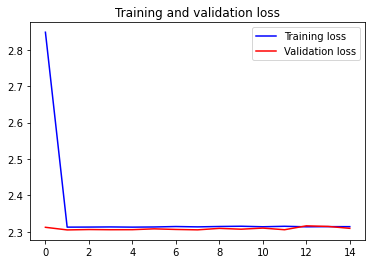

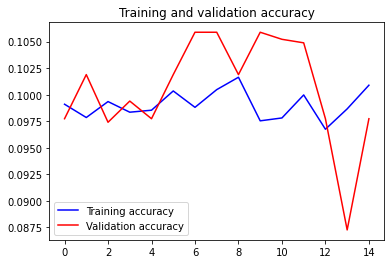

In [15]:
output_folder='figures'

plot_losses(train_loss, test_loss, save_to_file=os.path.join(output_folder, 'loss_plot_200p.png'))
plot_accuracies(train_acc, test_acc, save_to_file=os.path.join(output_folder, 'accuracy_plot_200p.png'))

#Test model

In [16]:

def infer(dataset,
          model,
          point_cloud_file,
          shuffle_points=False,
          plot_tNet_out=True,
          return_indices_maxpool=False):
    
    num_classes = dataset.NUM_CLASSIFICATION_CLASSES
    points, label = point_cloud_file
    
    if torch.cuda.is_available():
        points = points.cuda()
        model.cuda()

    points = points.unsqueeze(dim=0)
    model = model.eval()
    preds, feature_transform, tnet_out, ix = model(points)
    preds = preds.data.max(1)[1]

    points = points.cpu().numpy().squeeze()
    preds = preds.cpu().numpy()

    if return_indices_maxpool:
        return preds, tnet_out, ix

    return preds, tnet_out

Compute accuracy on test set

In [17]:
from tqdm.notebook import tqdm
corrects=0

# load checkpoint
# model_checkpoint = '/content/checkpoints/3Dmnist_checkpoint_200.pth'
# if model_checkpoint:
#     state = torch.load(model_checkpoint, map_location=torch.device(device))
#     model.load_state_dict(state['model'])  

for i in tqdm(range(len(test_dataset))):
    target=test_dataset[i][1]
    pred, tnet_out = infer(dataset_3d, model, test_dataset[i], shuffle_points=False, plot_tNet_out=False)    
    if target == pred:
        corrects+=1

print(f'Accuracy = {corrects/len(test_dataset)}')

  0%|          | 0/6000 [00:00<?, ?it/s]

Accuracy = 0.098


Plot input and output of T-Net

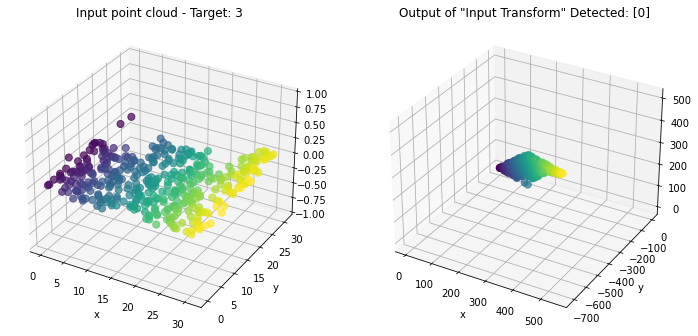

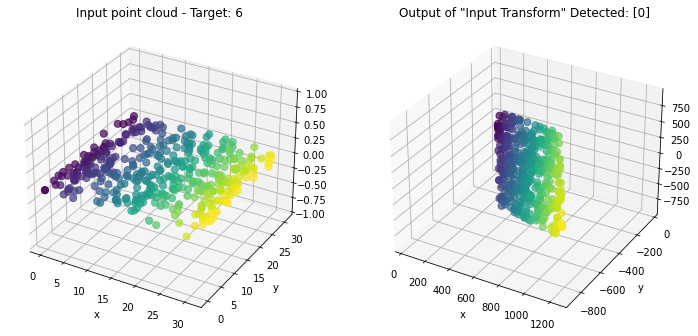

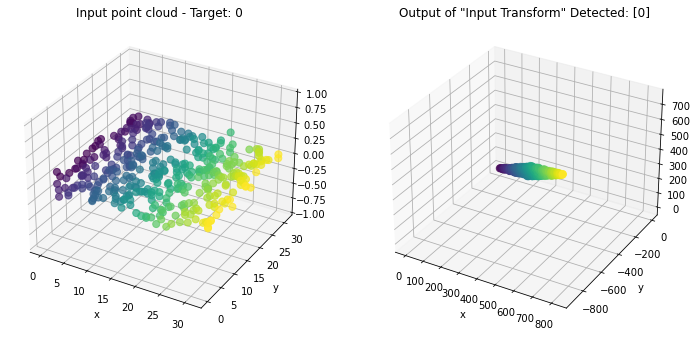

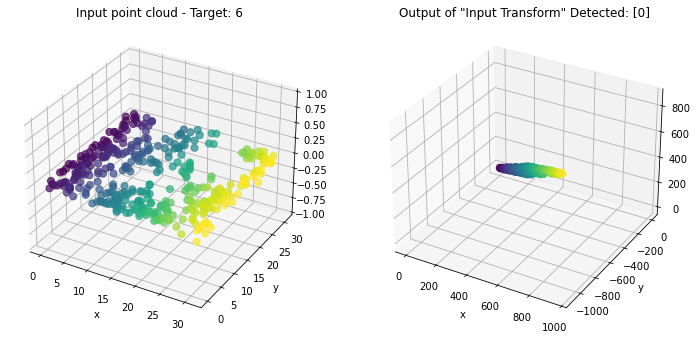

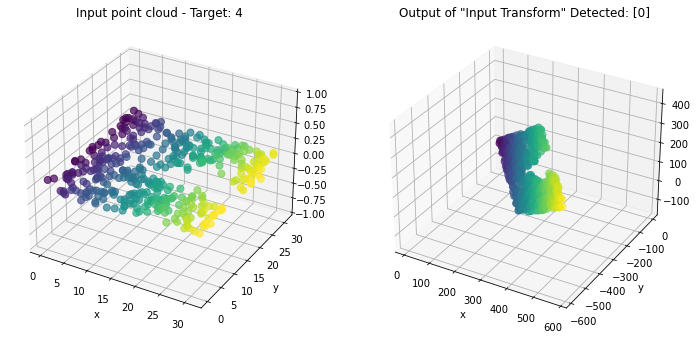

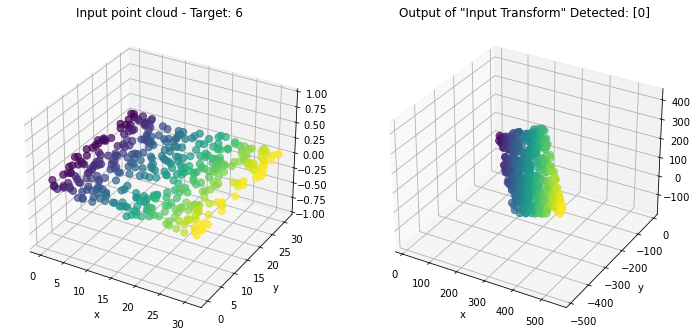

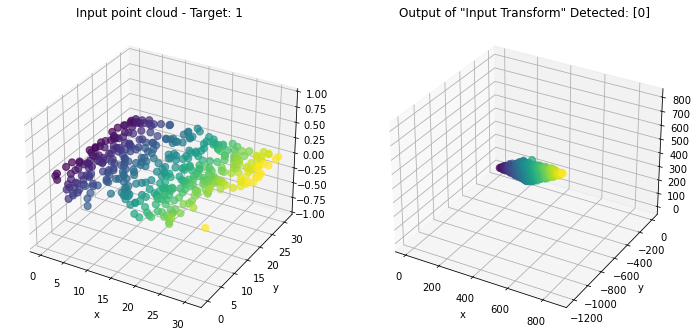

In [18]:
# Plot 7 samples
for SAMPLE in range(7):

    fig = plt.figure(figsize=[12,6])
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    # plot input sample
    pc = test_dataset[SAMPLE][0].numpy()
    label = test_dataset[SAMPLE][1]
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=50, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    ax.title.set_text(f'Input point cloud - Target: {label}')

    # plot transformation
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    preds, tnet_out = infer(dataset_3d, model,test_dataset[SAMPLE])
    points=tnet_out
    sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=50, marker='o', cmap="viridis", alpha=0.7)
    ax.title.set_text(f'Output of "Input Transform" Detected: {preds}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.savefig(f'figures/Tnet-out-{label}.png',dpi=100)

    #print('Detected class: %s' % preds)


One of the properties of PointNet is that it is invariant to permutations of points. Let's test it! We are going to shuffle points and visualize the transformation.

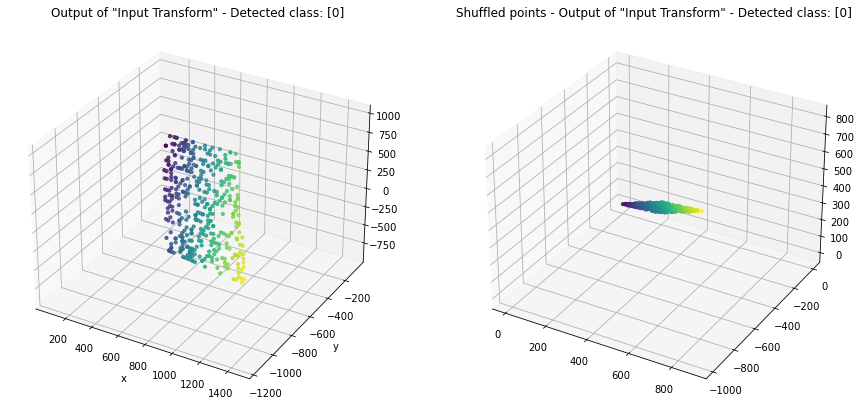

In [19]:
# select sample from test dataset
SAMPLE=1 

fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(1, 2, 1, projection='3d')
label = test_dataset[SAMPLE][1]

# plot transformation
preds, tnet_out = infer(dataset_3d, model, test_dataset[SAMPLE])
points=tnet_out
sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=10, marker='o', cmap="viridis", alpha=0.8)
ax.title.set_text('Output of "Input Transform" - Detected class: %s' % preds)
ax.set_xlabel('x')
ax.set_ylabel('y')

# plot transformation with shuffled points
ax = fig.add_subplot(1, 2, 2, projection='3d')
preds, tnet_out = infer(dataset_3d, model, test_dataset[SAMPLE], shuffle_points=True)
points=tnet_out
sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=10, marker='o', cmap="viridis", alpha=0.8)
ax.title.set_text('Shuffled points - Output of "Input Transform" - Detected class: %s' % preds)
plt.savefig(f'figures/Tnet-out-shuffle-{label}.png',dpi=100)

plt.show()


In [20]:
from tqdm.notebook import tqdm
results=[]
results_shuffle=[]
tnet_out_list =[]
tnet_out_shuffle_list =[]
list_ix_o = []
list_ix_shuffle = []

for i in tqdm(range(len(test_dataset))):
    preds, tnet_out, ix_o = infer(dataset_3d, model, test_dataset[i], shuffle_points=False, 
                                        plot_tNet_out=False, return_indices_maxpool=True)    
    results.append(int(preds))
    tnet_out_list.append(tnet_out) # store output of T-Net
    list_ix_o.append(ix_o.cpu()) # store max-poolng indices
    
    preds, tnet_out_shuf, ix_shuffle = infer(dataset_3d, model, test_dataset[i], shuffle_points=True,
                                         plot_tNet_out=False, return_indices_maxpool=True)    
    
    results_shuffle.append(int(preds))
    tnet_out_shuffle_list.append(tnet_out_shuf)
    list_ix_shuffle.append(ix_shuffle.cpu())
    
    
    
    

  0%|          | 0/6000 [00:00<?, ?it/s]

In [21]:
# Get index of different predictions
idx=0
res=[]
# With iteration
for i in results:
    if results[idx] != results_shuffle[idx]:
        res.append(idx)
    idx = idx + 1

# Result
print("The index positions with mismatched values:\n",res)

The index positions with mismatched values:
 []


Sample: 1234


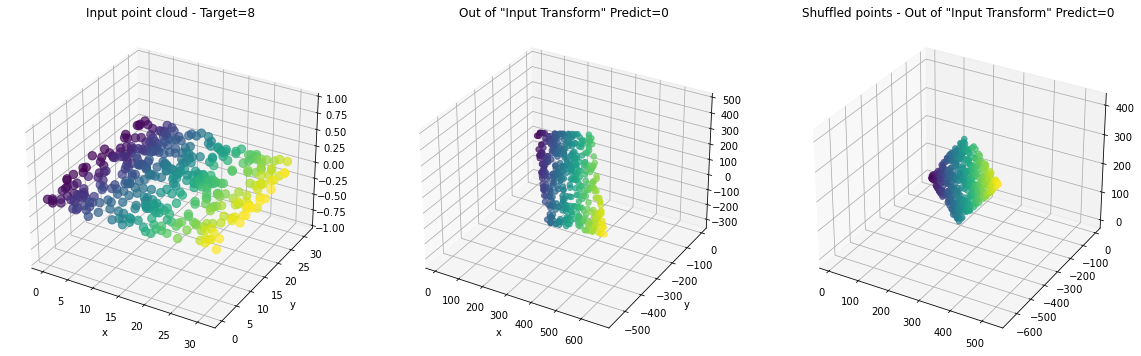

In [24]:
# select sample from test dataset
res = [1234]
for i in range(len(res)):
    SAMPLE=res[i]

    fig = plt.figure(figsize=[20,6])
    input_points = test_dataset[SAMPLE][0]
    label = test_dataset[SAMPLE][1]
    print(f'Sample: {SAMPLE}')

    # plot input sample
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    pc = test_dataset[SAMPLE][0].numpy()
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=70, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    ax.title.set_text(f'Input point cloud - Target={label}')

    # plot transformation
    ax = fig.add_subplot(1, 3, 2, projection='3d')

    preds = results[SAMPLE]
    points = tnet_out_list[SAMPLE]

    sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=30, marker='o', 
                    cmap="viridis", alpha=0.7)
    ax.title.set_text('Out of "Input Transform" Predict=%s' % preds)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # plot transformation with shuffled points
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    preds = results_shuffle[SAMPLE]
    points = tnet_out_shuffle_list[SAMPLE]
    sc = ax.scatter(points[0,0,:], points[0,1,:], points[0,2,:], c=points[0,0,:] ,s=30, marker='o', 
                    cmap="viridis", alpha=0.7)
    ax.title.set_text('Shuffled points - Out of "Input Transform" Predict=%s' % preds)
    plt.show()
    


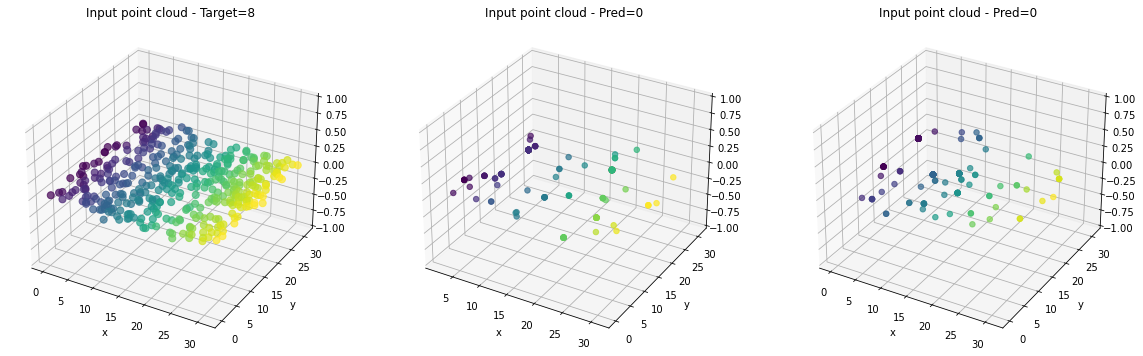

In [25]:
# select sample from test dataset
for k in range(len(res)):
    SAMPLE = res[k]

    pc = test_dataset[SAMPLE][0].numpy()
    fig = plt.figure(figsize=[20,6])
    input_points = test_dataset[SAMPLE][0]
    label = test_dataset[SAMPLE][1]

    # plot input sample
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=50, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    ax.title.set_text(f'Input point cloud - Target={label}')

    # plot critical points
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    pc1 = pc[list(set(list_ix_o[0].reshape(256))), :]
    sc = ax.scatter(pc1[:,0], pc1[:,1], pc1[:,2], c=pc1[:,0] ,s=30, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    preds = results[SAMPLE]
    ax.title.set_text(f'Input point cloud - Pred={preds}')
    
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    pc = test_dataset[SAMPLE][0].numpy()
    pc = pc[list(set(list_ix_shuffle[0].reshape(256))), :]
    sc = ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=pc[:,0] ,s=30, marker='o', cmap="viridis", alpha=0.7)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlim3d(-1, 1)
    preds = results_shuffle[SAMPLE]
    ax.title.set_text(f'Input point cloud - Pred={preds}')